In [2]:
import os

# Third-party
from astropy.io import fits
import astropy.time as atime
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline

from ebak.singleline import RVData, OrbitModel
from ebak.units import usys
from ebak import SimulatedRVOrbit

PLOT_PATH = "../plots/troup-fits"
if not os.path.exists(PLOT_PATH):
    os.mkdir(PLOT_PATH)

In [3]:
troup = np.genfromtxt("../data/troup16-dr12.csv", delimiter=",", names=True, dtype=None)

In [4]:
allVisit = fits.getdata("../data/allVisit-l30e.2.fits", 1)

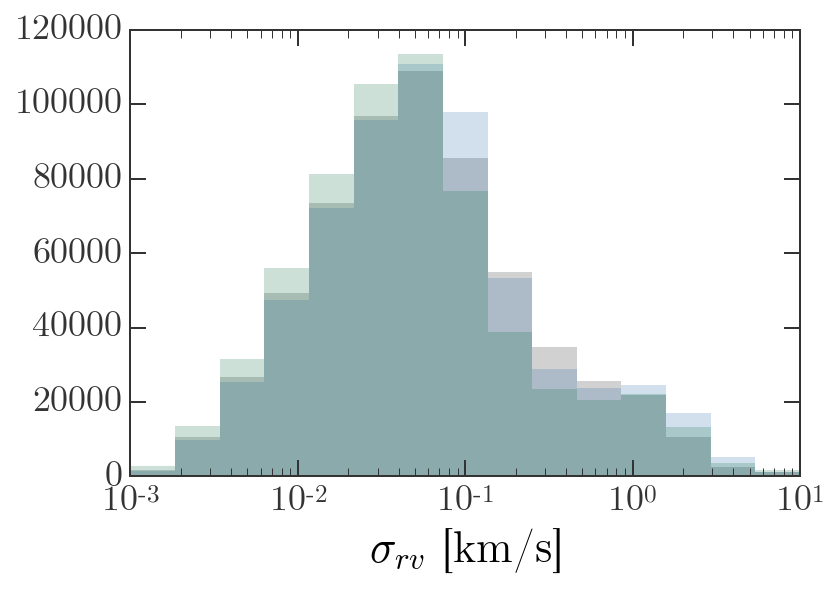

In [4]:
v_err_max = np.nanmax(np.vstack((allVisit['VRELERR'], allVisit['ESTVRELERR'], allVisit['SYNTHVRELERR'])), axis=0)

bins = np.logspace(-3,1,16)
#plt.hist(v_err_max, bins=bins)

for _verr in [allVisit['VRELERR'], allVisit['ESTVRELERR'], allVisit['SYNTHVRELERR']]:
    plt.hist(_verr[np.isfinite(_verr)], bins=bins, alpha=0.2)

plt.xscale('log')
plt.xlabel(r'$\sigma_{rv}$ [km/s]')

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


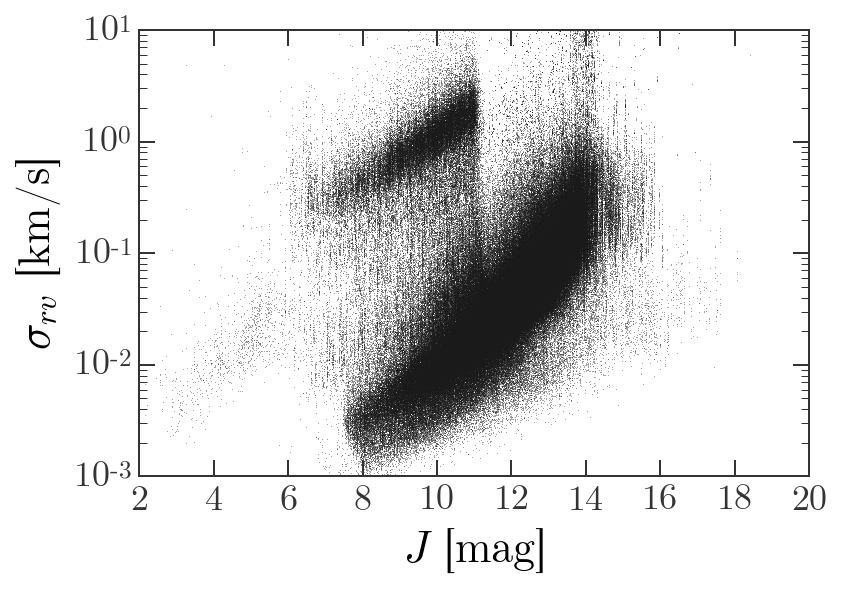

In [5]:
plt.plot(allVisit['J'], allVisit['VRELERR'], ls='none', alpha=0.4, marker=',')
plt.yscale('log')
plt.xlim(2, 20)
plt.ylim(1E-3, 1E1)

plt.xlabel('$J$ [mag]')
plt.ylabel(r'$\sigma_{rv}$ [km/s]')

[ 285.66271174] m / s
[ 1986.18529716] m / s
[ 7105.02343624] m / s


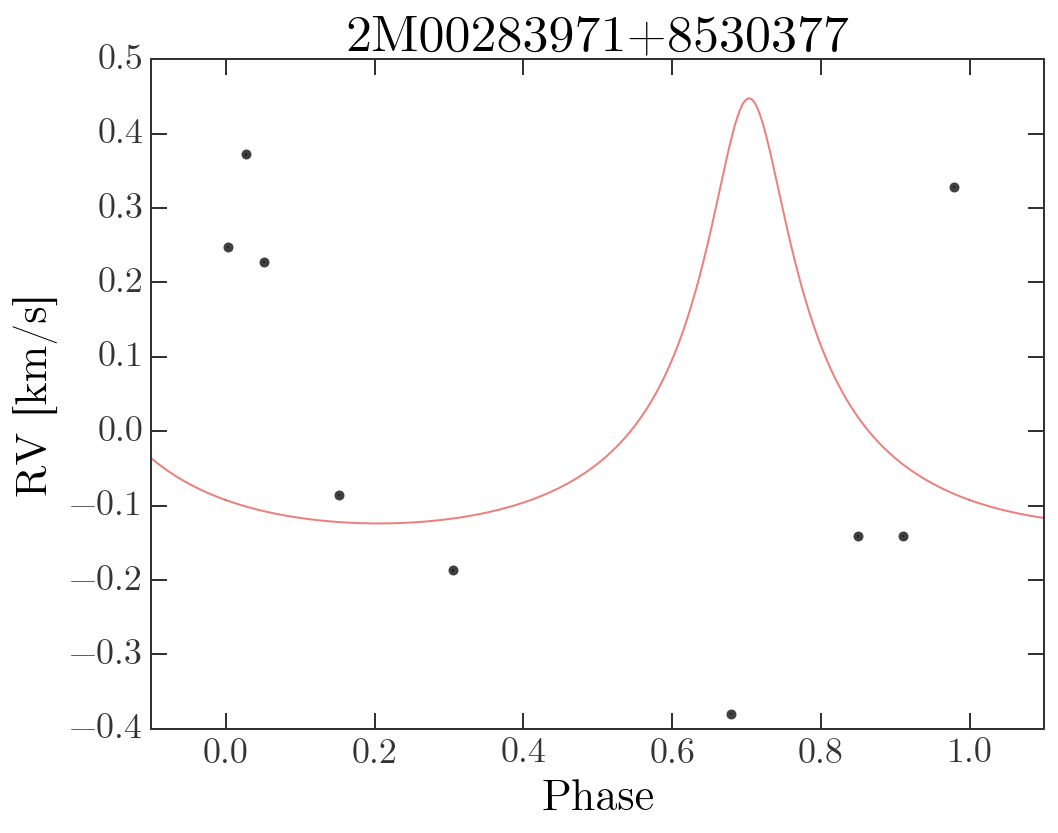

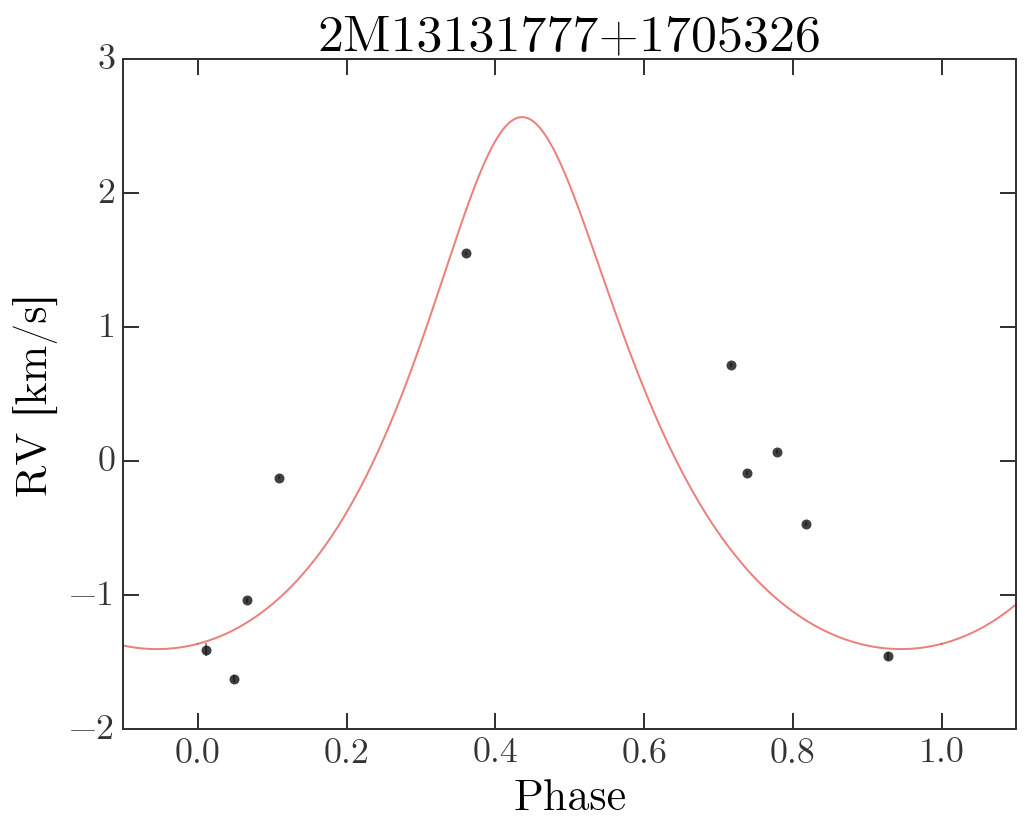

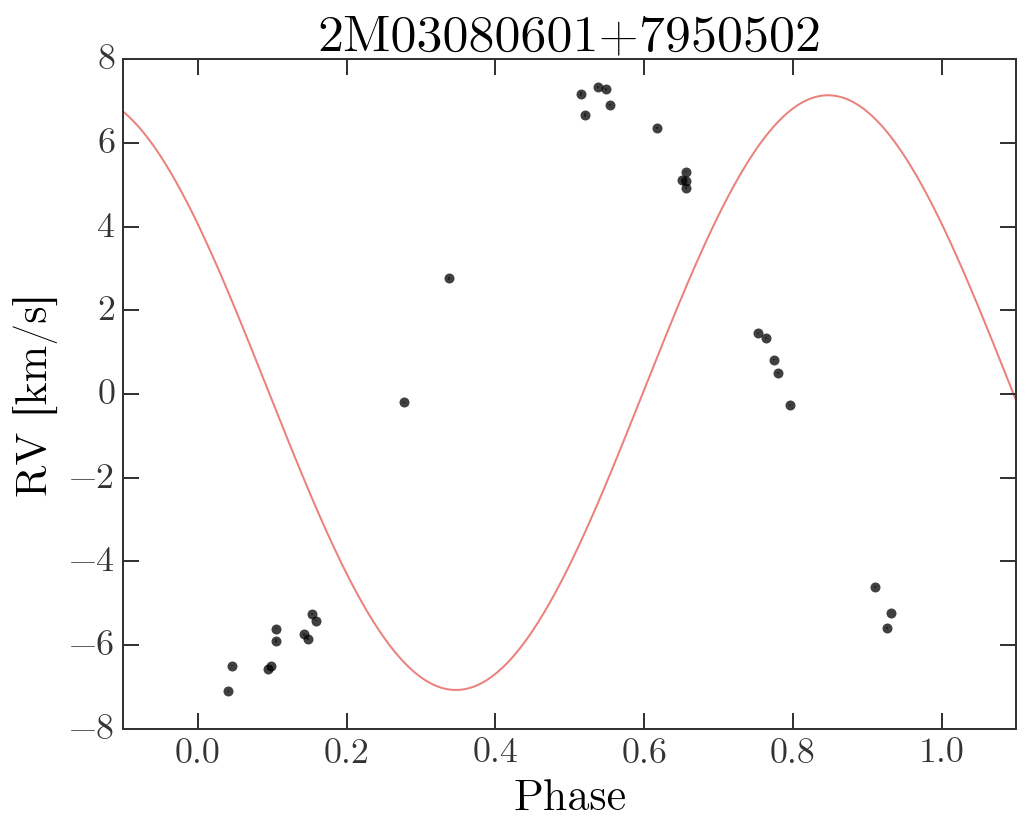

In [16]:
# Make the same panels as Figure 5 in Troup+2016
troup_ids = ['2M00283971+8530377', '2M13131777+1705326', '2M03080601+7950502']

data_style = dict(marker='o', ecolor='#666666', linestyle='none', 
                  alpha=0.75, color='k', label='APOGEE data')
model_style = dict(marker=None, linestyle='-', color='#de2d26', 
                   alpha=0.6, label='Troup orbit')

for apogee_id in troup_ids:
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    
    target = allVisit[allVisit['APOGEE_ID'].astype(str) == apogee_id]
    troup_row = troup[troup['APOGEE_ID'].astype(str) == apogee_id]
        
    # get APOGEE data for RV measurements
    data_t = atime.Time(target['JD'], format='jd', scale='tcb') # TODO: is this Barycentric?
    data_rv = np.array(target['VHELIO']) * u.km/u.s
    data_rv_err = (np.array(target['VRELERR'])*u.km/u.s)**2 # TODO: is this the correct uncertainty to use?
    
    # convert data time to phase
    P = troup_row['PERIOD'] * u.day
    t0 = atime.Time(troup_row['T0'], format='jd', scale='tcb') # TODO: is this Barycentric?
    data_phase = ((data_t - t0) / P) % 1.
    
    # get orbital parameters
    ecc = troup_row['ECC']
    K = troup_row['SEMIAMP']*u.m/u.s
    print(K)
    mf,asini = SimulatedRVOrbit.P_K_ecc_to_mf_asini_ecc(P, K, ecc)
    omega = troup_row['OMEGA']*u.degree
    phi0 = 2*np.pi * (((t0.tcb.mjd - 55555.) / P.to(u.day).value) % 1.) * u.radian
    
    troup_orbit = SimulatedRVOrbit(P=P, a_sin_i=asini, ecc=ecc, 
                                   omega=omega, phi0=phi0, v0=0*u.km/u.s)
    
    # remove long-period velocity trend from data
    v0 = troup_row['V0']*u.m/u.s
    acc = troup_row['SLOPE']*u.m/u.s/u.day
    v_trend = v0 + acc*data_t.jd*u.day
    data_rv = data_rv - v_trend # TODO: is this how the data are plotting in Troup?
    
    # generate times to evaluate model from minimum time to time + 1 period
    model_t = data_t.min() + atime.TimeDelta(np.linspace(0, P.value, 1024)*P.unit)
    model_rv = troup_orbit.generate_rv_curve(model_t).to(u.km/u.s)
    model_phase = ((model_t - t0) / P) % 1.
    idx = model_phase.argsort()
    
    ax.plot(model_phase[idx], model_rv[idx], **model_style)
    ax.plot(model_phase[idx]-1, model_rv[idx], **model_style)
    ax.plot(model_phase[idx]+1, model_rv[idx], **model_style)
    
    ax.errorbar(data_phase, data_rv.value, data_rv_err.value, **data_style)
    
    ax.set_xlim(-0.1,1.1)
    ax.set_xlabel("Phase")
    ax.set_ylabel("RV [km/s]")
    ax.set_title(apogee_id)
    
#     fig.savefig(os.path.join(PLOT_PATH, "{}.png".format(troup_row['APOGEE_ID'].astype(str))), dpi=72)